In [4]:
!pip install rouge
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import re
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

from transformers import BertTokenizer, TFBertModel
from rouge import Rouge
summary = pd.read_csv('/content/drive/MyDrive/News/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('/content/drive/MyDrive/News/news_summary_more.csv', encoding='iso-8859-1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pre1 =  raw.iloc[:,0:2].copy()
# pre1['head + text'] = pre1['headlines'].str.cat(pre1['text'], sep =" ")

pre2 = summary.iloc[:,0:6].copy()
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

pre1=pre1.head(1000)
pre2=pre2.head(1000)

In [6]:
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']],ignore_index = True)

In [7]:
pre.head(2)


,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...


In [8]:
#LSTM with Attention
!pip install keras-self-attention

pre['text'][:10]

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=96ba1c078a546864717ef788ea0489bdc3eb2c6f2c9d5a92192d3a62f72ca5f6
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


,text
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Kunal Shah's credit card bill payment platform...
2,New Zealand defeated India by 8 wickets in the...
3,"With Aegon Life iTerm Insurance plan, customer..."
4,Speaking about the sexual harassment allegatio...
5,Pakistani singer Rahat Fateh Ali Khan has deni...
6,India recorded their lowest ODI total in New Z...
7,Weeks after ex-CBI Director Alok Verma told th...
8,Andhra Pradesh CM N Chandrababu Naidu has said...
9,Congress candidate Shafia Zubair won the Ramga...


In [9]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:

        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!

        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower()
        row=re.sub("(\\n)", ' ', str(row)).lower()

        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively

        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!

        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM


        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)

        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them



        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces

        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces



        yield row

In [10]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

In [14]:
from time import time
import spacy
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
#If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell , decrease the batch_size parametre

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
# The n_threads argument has been removed. spaCy now automatically manages threading.
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Time to clean up everything: 0.92 mins


In [ ]:
from time import time
import spacy
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])

t = time()

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 48.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Time to clean up everything: 0.07 mins


In [17]:
text[0]


'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [18]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [19]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

In [20]:
text_count = []
summary_count = []


In [21]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [22]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

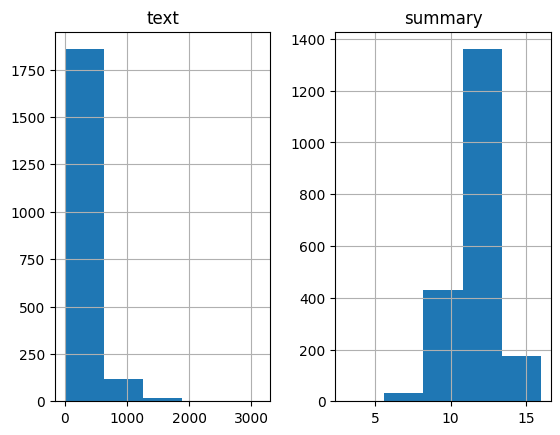

In [23]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [24]:
#Check how much % of summary have 0-15 words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.994


In [25]:
#Check how much % of text have 0-70 words
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

0.5055


In [26]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15

In [27]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [28]:
post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...


In [29]:
#Add sostok and eostok at
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [30]:
post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...


In [31]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [33]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [34]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.60757083659985
Total Coverage of rare words: 18.843851024351054


In [35]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 2179


In [36]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [37]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 92.96939619520265
Total Coverage of rare words: 40.9997634629031


In [38]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 256


In [39]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [40]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K
import gensim
from numpy import *
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 2179


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 200)       │        435,800 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 100, 300),     │        601,200 │ embedding[0][0]        │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 100, 300),     │        721,200 │ lstm[0][0]             │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 200)      │         51,200 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 100, 300),     │        721,200 │ lstm_1[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 300),    │        601,200 │ embedding_1[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_2[0][1],          │
│                           │ 300)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 256)      │         77,056 │ lstm_3[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,208,856 (12.24 MB)

 Trainable params: 3,208,856 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [44]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


In [46]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=25,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - loss: 2.3669 - val_loss: 2.1229
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - loss: 2.1901 - val_loss: 1.9402
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - loss: 2.0033 - val_loss: 2.1850
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - loss: 2.0960 - val_loss: 1.8077
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - loss: 1.8517 - val_loss: 1.7875
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - loss: 1.8528 - val_loss: 1.7641
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - loss: 1.8293 - val_loss: 1.7740
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - loss: 1.7955 - val_loss: 1.6640
Epoch 9/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - loss: 1.7384 - val_loss: 1.6550
Epoch 10/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - loss: 1.7228 - val_loss: 1.6347
Epoch 11/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - loss: 1.7303 - val_loss: 1.6412
Epoch 12/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - loss: 1.7280 - val_loss: 1.6550
Epoch 12: ear

In [47]:
import os

# Save the model to the current directory or a specific path
model_path = '/content/drive/MyDrive/News/news_model.h5'  # Specify the path where you want to save the model
model.save(model_path)


In [49]:
from sklearn.metrics import classification_report
import numpy as np

# Predict using the model
y_pred = model.predict([x_val, y_val[:,:-1]])
y_pred = np.argmax(y_pred, axis=-1)  # Get the class with the highest probability

# Flatten the true labels to match the shape of predictions
y_true = y_val[:, 1:]

# Iterate over output columns and print classification report for each
for i in range(y_true.shape[1]):
    print(f"Classification report for output column {i + 1}:")
    print(classification_report(y_true[:, i], y_pred[:, i]))
    print("-" * 30) # Add a separator between reports

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 802ms/step
Classification report for output column 1:
              precision    recall  f1-score   support

           2       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

------------------------------
Classification report for output column 2:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           5       0.08      1.00      0.15         8
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       0.00      0